<a href="https://colab.research.google.com/github/palver7/deeplearning/blob/master/FashionMNIST_with_ResNet50_no_resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from torchvision.datasets import FashionMNIST
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import random_split,DataLoader
import os
import copy

plt.ion()

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
samples = 100 #num of sample per batch
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(224),
        transforms.Grayscale(3),
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

trainset = FashionMNIST(root='./data', train=True, 
                        download=True, transform=data_transforms['train'])

trainset, valset = random_split(trainset, (50000,10000))

trainloader = DataLoader(trainset, batch_size=samples, shuffle=True, 
                                          num_workers=4)

testset = FashionMNIST(root='./data', train=False, 
                       download=True,transform=data_transforms['test'])

testloader = DataLoader(testset, batch_size=samples, shuffle=False, 
                                         num_workers=4)

valloader = DataLoader(valset, batch_size=samples, shuffle=False, 
                                         num_workers=4)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {'train': trainloader, 'val': valloader, 'test': testloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Trouser T-shirt/top Pullover Sandal Ankle Boot  Coat  Coat   Bag Pullover T-shirt/top


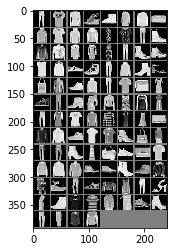

In [4]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [0]:
def train_model(model, criterion, optimizer, scheduler, val_acc, 
                val_loss, train_acc, train_loss, 
                num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    list = {'train': {'acc': train_acc, 'loss': train_loss}, 
        'val':{'acc': val_acc, 'loss': val_loss}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
        
            running_loss = 0.0
            running_corrects = 0
        
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                # zero the parameter gradients
                optimizer.zero_grad()
        
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            list[phase]['loss'].append(epoch_loss)
            list[phase]['acc'].append(epoch_acc.item())
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
        
    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model

In [0]:
model = models.resnet50(pretrained=False)
#for param in model.parameters():
#    param.requires_grad = False


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
# Lists for plotting loss and accuracy.
# Rerun this cell if you want to restart training to empty the lists.
val_acc = []
val_loss = []
train_acc = []
train_loss = []

In [8]:
model = train_model(model, criterion, optimizer, scheduler, val_acc, val_loss, 
                    train_acc, train_loss, num_epochs=5)

Epoch 0/4
----------
train Loss: 1.9676 Acc: 0.3029
val Loss: 1.7499 Acc: 0.3896

Epoch 1/4
----------
train Loss: 1.7032 Acc: 0.4011
val Loss: 1.6427 Acc: 0.4319

Epoch 2/4
----------
train Loss: 1.6449 Acc: 0.4230
val Loss: 1.5935 Acc: 0.4493

Epoch 3/4
----------
train Loss: 1.6046 Acc: 0.4394
val Loss: 1.5929 Acc: 0.4392

Epoch 4/4
----------
train Loss: 1.5834 Acc: 0.4453
val Loss: 1.5731 Acc: 0.4574

Training complete in 54m 1s
Best val Acc: 0.457400


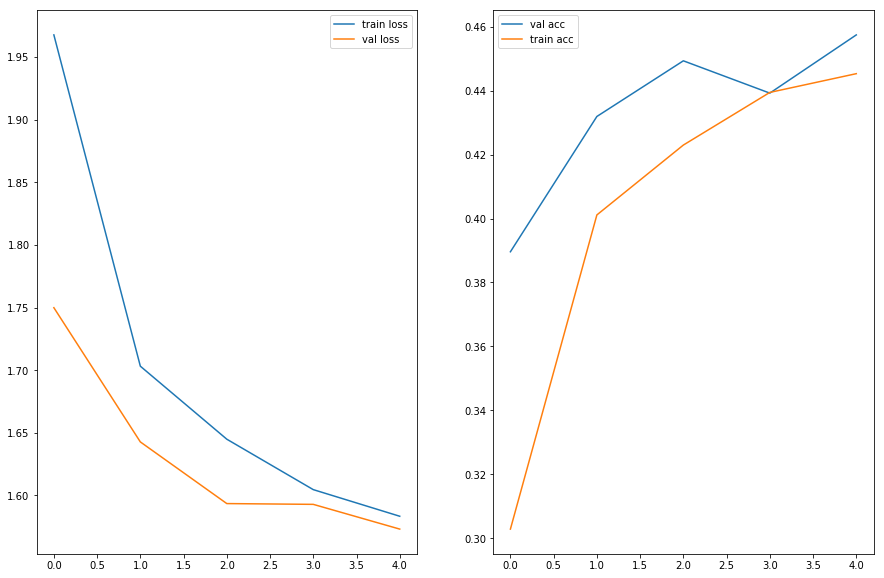

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(train_loss, label='train loss')
ax1.plot(val_loss, label='val loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(val_acc, label='val acc')
ax2.plot(train_acc, label='train acc')
ax2.legend()

GroundTruth:  Ankle Boot Pullover Trouser Trouser Shirt Trouser  Coat Shirt Sandal Sneaker


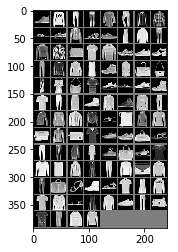

In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] \
                                for j in range(10)))

Predicted:  Sandal   Bag Trouser Trouser Shirt Trouser   Bag Sandal Sneaker   Bag


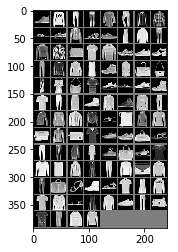

In [11]:
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
imshow(torchvision.utils.make_grid(images.cpu()))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] \
                              for j in range(10)))

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on the test images : %.4f' %
     (correct/total))

Accuracy of the network on the test images : 0.4507


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
      
for i in range(10):
    print('Accuracy of %5s : %.4f' % 
         (classes[i], class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 0.3900
Accuracy of Trouser : 0.6762
Accuracy of Pullover : 0.0851
Accuracy of Dress : 0.4565
Accuracy of  Coat : 0.4579
Accuracy of Sandal : 0.4944
Accuracy of Shirt : 0.2828
Accuracy of Sneaker : 0.5510
Accuracy of   Bag : 0.6415
Accuracy of Ankle Boot : 0.5182


Comparing training and validation accuracy and the training time of feature extraction (freezing the backpropagation), finetuning the model (use pretrained model, not freezing the backpropagation), and training the model from scratch ( no pretrained model).

###the feature extraction results are:

Epoch 0/4
----------
train Loss: 0.9161 Acc: 0.7452
val Loss: 0.6308 Acc: 0.7980

Epoch 1/4
----------
train Loss: 0.5967 Acc: 0.8051
val Loss: 0.5596 Acc: 0.8103

Epoch 2/4
----------
train Loss: 0.5419 Acc: 0.8178
val Loss: 0.5269 Acc: 0.8202

Epoch 3/4
----------
train Loss: 0.5125 Acc: 0.8259
val Loss: 0.5067 Acc: 0.8260

Epoch 4/4
----------
train Loss: 0.4929 Acc: 0.8306
val Loss: 0.4948 Acc: 0.8276

Training complete in 73m 54s
Best val Acc: 0.827600



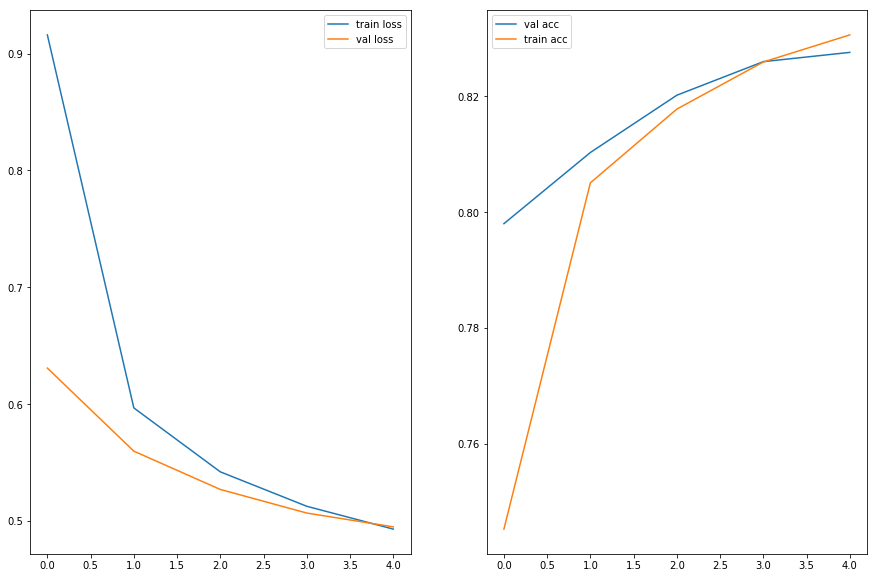

Result of transfer learning with frozen backpropagation using ResNet50.